In [1]:
# based on a notebook from kaggle
# https://www.kaggle.com/search?q=tag%3A%22bayesian+statistics%22+in%3Anotebooks

In [2]:
# imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams.update({'font.size': 22})
mpl.rcParams.update({'figure.figsize': (8, 8)})

In [3]:
# set seed
np.random.seed(0)

In [4]:
# generate data
def generate_samples(m, b, size=20):
    x = np.random.random(size) * 75 + 2
    y = m*x + b
    
    y_range = (y.max() - y.min())
    
    sigma = np.random.randn(size) * 0.1 * y_range
    sigma = sigma + 2 * (sigma/abs(sigma))
    
    
    y = y + sigma
    
    return x, y, sigma

In [5]:
m_true, b_true = 0.736, 30
x, y, y_err = generate_samples(m_true, b_true)

In [6]:
def plot_data(x, y, y_err):
    plt.figure()
    plt.errorbar(x, y, yerr=y_err, color='black', linestyle='', marker='^', capsize=4)
    plt.xlim([x.min() - 30, x.max() + 30])
    plt.ylim([y.min() - 50, y.max() + 50])
    plt.xlabel('x')
    plt.ylabel('y')

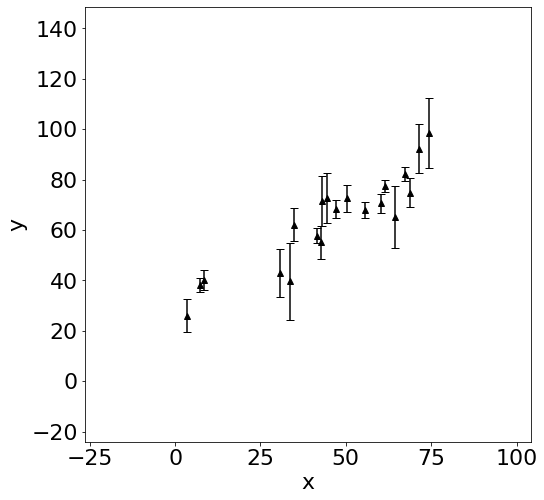

In [7]:
plot_data(x, y, y_err)

In [8]:
# our goal is to find the posterior distribution for the parameters
# of our model

# our model is
# model(x) = m*x + b

# our posterior is
# p([m,b]|y)

# via Bayes' theorem
# p([m,b]|y) = p(y|[m,b]) * p([m,b]) / p(y)
# posterior = likelihood * prior / evidence

# we can take the natural logarithm to go from multiplication and division to addition and subtraction

# ln_post = ln_like + ln_prior - ln_evidence

In [9]:
def likelihood(parameters, x, y, error):
    m, b = parameters
    yhat = m*x + b

    vec = 1./(np.sqrt(2*np.pi*error**2)) * np.exp( - 0.5 * (y - yhat)**2/error)
    
    return np.prod(vec)

In [10]:
# take to natural log of the above.
# simplify the math to avoid numerical issues
def ln_likelihood(parameters, x, y, error):
    m, b = parameters
    yhat = m*x + b
    
    N = len(x)

    return -0.5 * (
        np.sum((N * np.log(2*np.pi*error**2)) 
               + np.sum( ((y-yhat)/error)**2 ))
    )

In [11]:
likelihood([m_true, b_true], x, y, y_err)

5.635932862908266e-25

In [12]:
ln_likelihood([m_true, b_true], x, y, y_err)

-1270.467266668893

In [13]:
np.exp(ln_likelihood([m_true, b_true], x, y, y_err))

0.0

In [14]:
# exp(ln_like) != like
# not a simple/linear transformation?

In [15]:
mmm = np.arange(m_true-0.1, m_true+0.1, 0.01)

In [16]:
lll = [likelihood([mm, b_true], x, y, y_err).sum() for mm in mmm]
ln_lll = [ln_likelihood([mm, b_true], x, y, y_err).sum() for mm in mmm]

In [17]:
lll

[2.0136458212544753e-68,
 9.83834614109836e-64,
 4.030539381629388e-59,
 1.3845425187691545e-54,
 3.9879663338291344e-50,
 9.631606410569716e-46,
 1.9505093142360764e-41,
 3.3120690900885183e-37,
 4.7157720534532376e-33,
 5.629998496489414e-29,
 5.635932862908707e-25,
 4.73069992301337e-21,
 3.3295615552596954e-17,
 1.9649466051809163e-13,
 9.723363377944002e-10,
 4.034449994146799e-06,
 0.01403635084574414,
 40.94738302991254,
 100161.34426027456,
 205435832.25283375]

In [18]:
ln_lll

[-1600.5350995359602,
 -1542.8397690922054,
 -1490.6307824611288,
 -1443.9081396427277,
 -1402.671840637005,
 -1366.9218854439598,
 -1336.6582740635918,
 -1311.8810064959007,
 -1292.5900827408877,
 -1278.7855027985515,
 -1270.4672666688925,
 -1267.6353743519114,
 -1270.2898258476075,
 -1278.4306211559808,
 -1292.0577602770318,
 -1311.1712432107595,
 -1335.7710699571653,
 -1365.8572405162477,
 -1401.4297548880077,
 -1442.488613072445]

In [19]:
np.exp(ln_lll)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

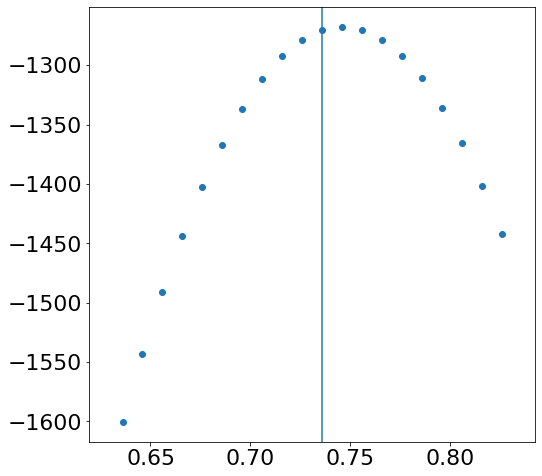

In [20]:
plt.figure()
# plt.scatter(mmm, lll)
plt.scatter(mmm, ln_lll)
plt.axvline(m_true)

In [21]:
mmm

array([0.636, 0.646, 0.656, 0.666, 0.676, 0.686, 0.696, 0.706, 0.716,
       0.726, 0.736, 0.746, 0.756, 0.766, 0.776, 0.786, 0.796, 0.806,
       0.816, 0.826])

In [22]:
# we have the log likelihood now we need the log prior

# if we are outside the prior then we want the likelihood to be zero.
# this means that the ln_likelihood should be ... -inf
# because exp(-inf) = 0.

def ln_prior(parameters, limits):
    
    m, b = parameters
    mlimits, blimits = limits
    
    if (m >= mlimits[0]) and (m <= mlimits[1]):
        # inside prior
        ln_uniform_prior_m = np.log(1./(mlimits[1] - mlimits[0]))
    else:
        # outside prior
        ln_uniform_prior_m = -np.inf
        
    if (b >= blimits[0]) and (b <= blimits[1]):
        # inside prior
        ln_uniform_prior_b = np.log(1./(blimits[1] - blimits[0]))
    else:
        # outside prior
        ln_uniform_prior_b = -np.inf
    
    # total ln_prior is just the sum of the ln_priors
    return ln_uniform_prior_m + ln_uniform_prior_b

In [23]:
ln_prior([1,1], [[-10, 10],[-10, 10]])

-5.991464547107982

In [24]:
# now we can compute the ln_posterior
def ln_posterior(parameters, x, y, error, param_limits):
    lnprior = ln_prior(parameters, param_limits)
    lnlike = ln_likelihood(parameters, x, y, error)
    
    return lnlike + lnprior

In [25]:
ln_posterior([1,1], x, y, y_err, [[-100, 100],[-100, 100]])

-4966.349017669475

In [26]:
ln_posterior([m_true, b_true], x, y, y_err, [[-100, 100],[-100, 100]])

-1281.0639014019891

In [27]:
m_true

0.736

In [28]:
b_true

30

In [29]:
# now we could grid this up in m and p (i.e. the parameters)
# but lets use the MH-MCMC algorithm to find the posterior
# for our parameters

In [30]:
def MH(posterior_fn, data, init_params, param_limits, stepsize, nsteps):
    x, y, error = data
    
    # intial ln_posterior
    current_lnpost = posterior_fn(init_params, x, y, error, param_limits)
    
    markov_chain = np.empty((nsteps, len(init_params)))
    lnposts = np.empty(nsteps)
    n_accepted = 0
    
    current_params = init_params
    
    for n in range(nsteps):
        new_params = current_params + stepsize * np.random.normal(0, 1, size=len(init_params))
        new_lnpost = posterior_fn(new_params, x, y, error, param_limits)
        
        if new_lnpost > current_lnpost:
            current_params = new_params
            current_lnpost = new_lnpost
            n_accepted = n_accepted + 1
        else:
            # accept with probability
            ln_alpha = np.log(np.random.uniform())
            # 
            ln_ratio = new_lnpost-current_lnpost
            if ln_ratio > ln_alpha:
                current_params = new_params
                current_lnpost = new_lnpost
                n_accepted = n_accepted + 1
            else:
                pass
        markov_chain[n] = current_params
        lnposts[n] = current_lnpost
        
    acceptance = n_accepted/nsteps
    return markov_chain, lnposts, acceptance

In [31]:
nsteps=10000

In [32]:
m_true

0.736

In [33]:
b_true

30

In [34]:
start_parameters = np.array([0.5, 10])
mlimits, blimits = ((0.01, 2), (0.1, 50))

stepsize_m = 0.002 * (mlimits[1] - mlimits[0])
stepsize_b = 0.005 * (blimits[1] - blimits[0])

stepsize = np.array([stepsize_m, stepsize_b])


chain, lnposts, acceptance = MH(ln_posterior, [x, y, y_err], start_parameters, (mlimits, blimits), stepsize, nsteps)

In [35]:
acceptance

0.5782

In [36]:
# chain

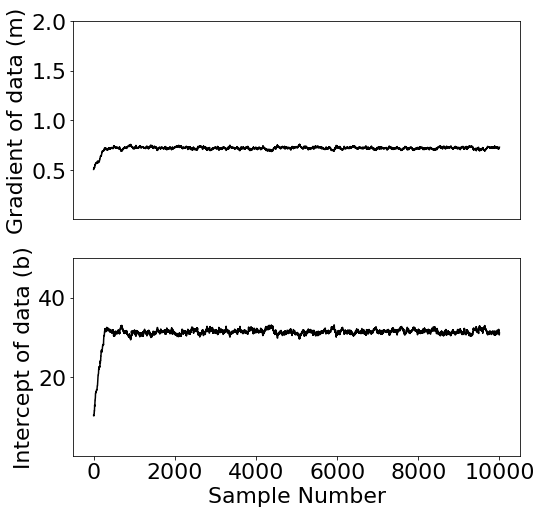

In [37]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(chain[:, 0], 'k-')
ax[0].set_ylabel("Gradient of data (m)")
ax[0].set_ylim(*mlimits)
ax[0].set_xticks([])
ax[1].set_ylabel("Intercept of data (b)")
ax[1].set_ylim(*blimits)
ax[1].set_xlabel("Sample Number")


ax[1].plot(chain[:, 1], 'k-')
plt.show()

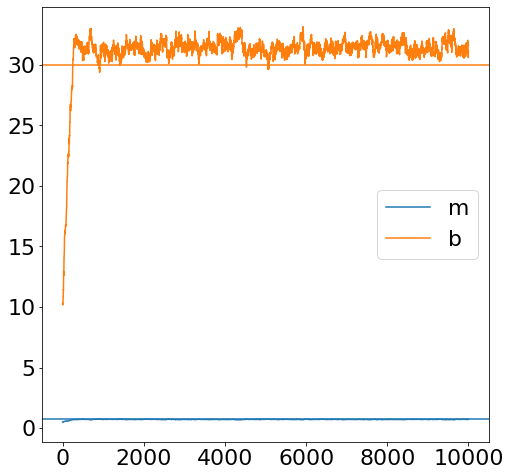

In [38]:
plt.figure()
plt.plot(np.arange(nsteps), chain[:,0], label='m')
plt.plot(np.arange(nsteps), chain[:,1], label='b')
plt.axhline(m_true, c='C0')
plt.axhline(b_true, c='C1')
plt.legend()
# plt.ylim(25, 35)

(array([0.00108833, 0.00082713, 0.00187192, 0.000653  , 0.00100126,
        0.00182839, 0.00082713, 0.00252492, 0.05868259, 0.36602615]),
 array([10.17876332, 12.47586697, 14.77297062, 17.07007427, 19.36717792,
        21.66428156, 23.96138521, 26.25848886, 28.55559251, 30.85269616,
        33.14979981]),
 <a list of 1 Patch objects>)

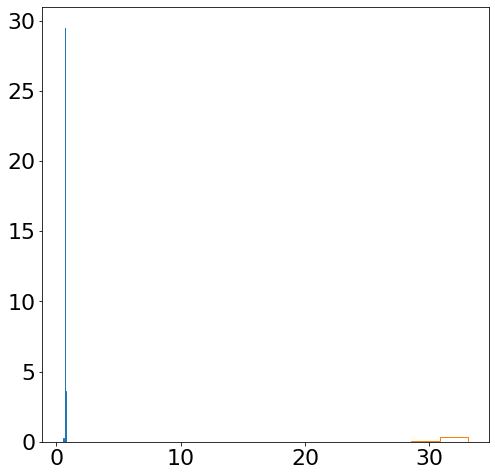

In [39]:
plt.figure()
plt.hist(chain[:,0], histtype='step', density=True)
plt.hist(chain[:,1], histtype='step', density=True)
# plt.axvline(m_true, c='C0')
# plt.axvline(b_true, c='C1')

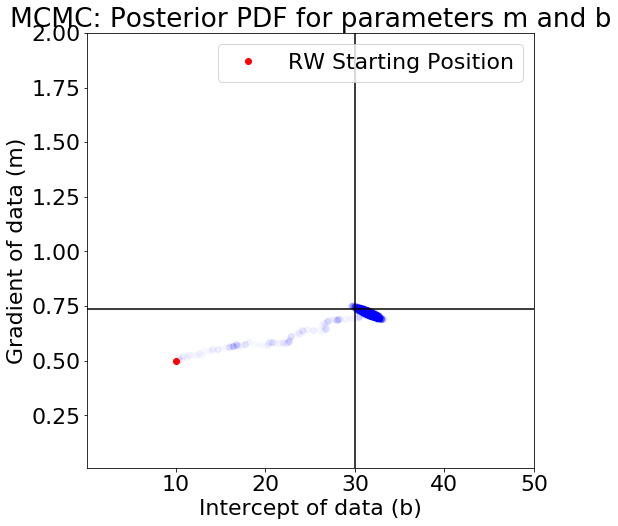

In [40]:
plt.figure()
plt.plot(chain[:, 1], chain[:, 0], linestyle="", marker='o', alpha=0.01, color="blue")
plt.plot(start_parameters[1], start_parameters[0], linestyle="", marker='o', alpha=1, color="red", label="RW Starting Position")
plt.ylim(*mlimits)
plt.xlim(*blimits)
plt.title("MCMC: Posterior PDF for parameters m and b")
plt.legend()
plt.ylabel("Gradient of data (m)")
plt.xlabel("Intercept of data (b)")
plt.axhline(m_true, c='k')
plt.axvline(b_true, c='k')
plt.show()

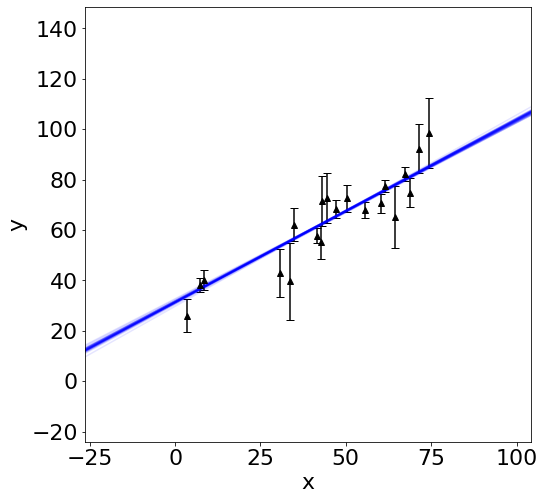

In [41]:
x_axis = np.linspace(x.min() - 30, x.max() + 30, 50)

plot_data(x, y, y_err)

for i in np.random.randint(len(chain), size=50):
    m, b = chain[i]
    plt.plot(x_axis, m* x_axis + b, color='blue', alpha=0.1)
plt.show()

# lets try to solve this with pymc3

In [42]:
import pymc3 as pm
import arviz as az

In [43]:
az.__version__

'0.11.0'

In [44]:
# the data

In [45]:
m_true

0.736

In [46]:
b_true

30

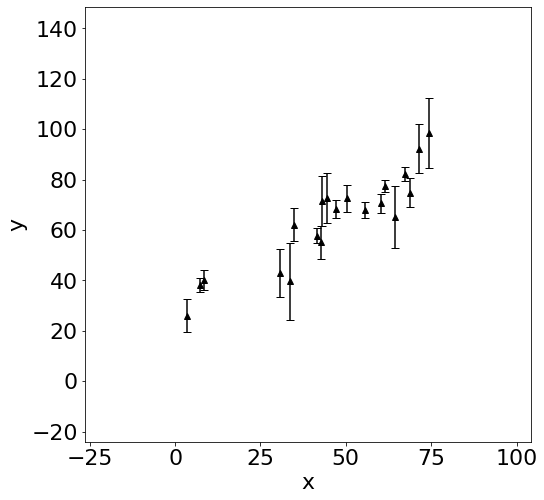

In [47]:
plot_data(x, y, y_err)

In [48]:
# the model

In [55]:
with pm.Model() as model:
    # prior for slope
    m = pm.Normal('m', mu=0, sd=10)
    # prior for intercept
    c = pm.Normal('c', mu=0, sd=10)
    # prior for noise
    n = pm.HalfCauchy('n', 10)
    # likelihood
    y = pm.Normal('y', mu=m*x + c, sd=n, observed=y)

TypeError: observed needs to be data but got: <class 'pymc3.model.ObservedRV'>

In [50]:
model

In [51]:
with model:
    start = pm.find_MAP()

In [52]:
start

{'m': array(0.87850362),
 'c': array(23.03964285),
 'n_log__': array(2.0470665),
 'n': array(7.7451474)}

In [53]:
with model:
#     step = pm.Metropolis()
    step = pm.NUTS()
    trace = pm.sample(10000, step=step, start=start)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n, c, m]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 29 seconds.
The acceptance probability does not match the target. It is 0.891690058197149, but should be close to 0.8. Try to increase the number of tuning steps.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2c47ec10>,
      dtype=object)

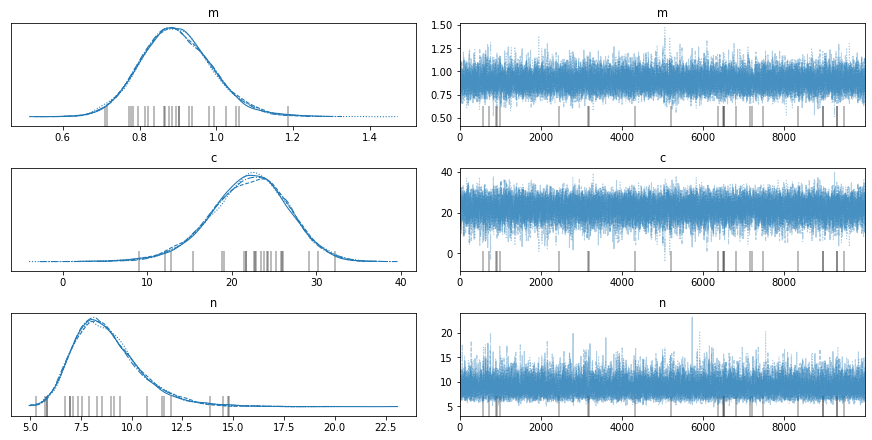

In [54]:
az.plot_trace(trace)